## Snakemake for Converting GMET Forcing to Snakemake ##

Initial workflow file to test capabilities of [snakemake](https://snakemake.readthedocs.io/en/stable/).



In [1]:
from IPython import display

In [104]:
%%writefile ../gmet_to_summa.smk
''' 
gmet to summa snakemake master snakemake file

This snakemake file runs all the steps required to convert GMET forcings to SUMMA forcings.

Original process code: Andy Wood
Adapted to Snakemake: Dave Casson
'''

from pathlib import Path
from scripts import gmet_to_summa_utils as utils

# Resolve paths from the configuration file
config = utils.resolve_paths(config)

# Read in all local snakemake files and rules
include: './rules/gmet_file_prep.smk'
include: './rules/remap_gmet_to_shp.smk'
include: './rules/metsim_file_prep.smk'
include: './rules/run_metsim.smk'
include: './rules/metsim_to_summa.smk'

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
_, file_path_list = utils.build_ensemble_list(config['gmet_forcing_dir'])

rule gmet_to_summa:
    input:
        expand(Path(config['summa_forcing_dir'],'{forcing_file}.nc'), forcing_file = file_path_list)
        

Overwriting ../gmet_to_summa.smk


In [106]:
! snakemake --unlock -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../gmet_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-13T170123.486319.snakemake.log


Building DAG of jobs...


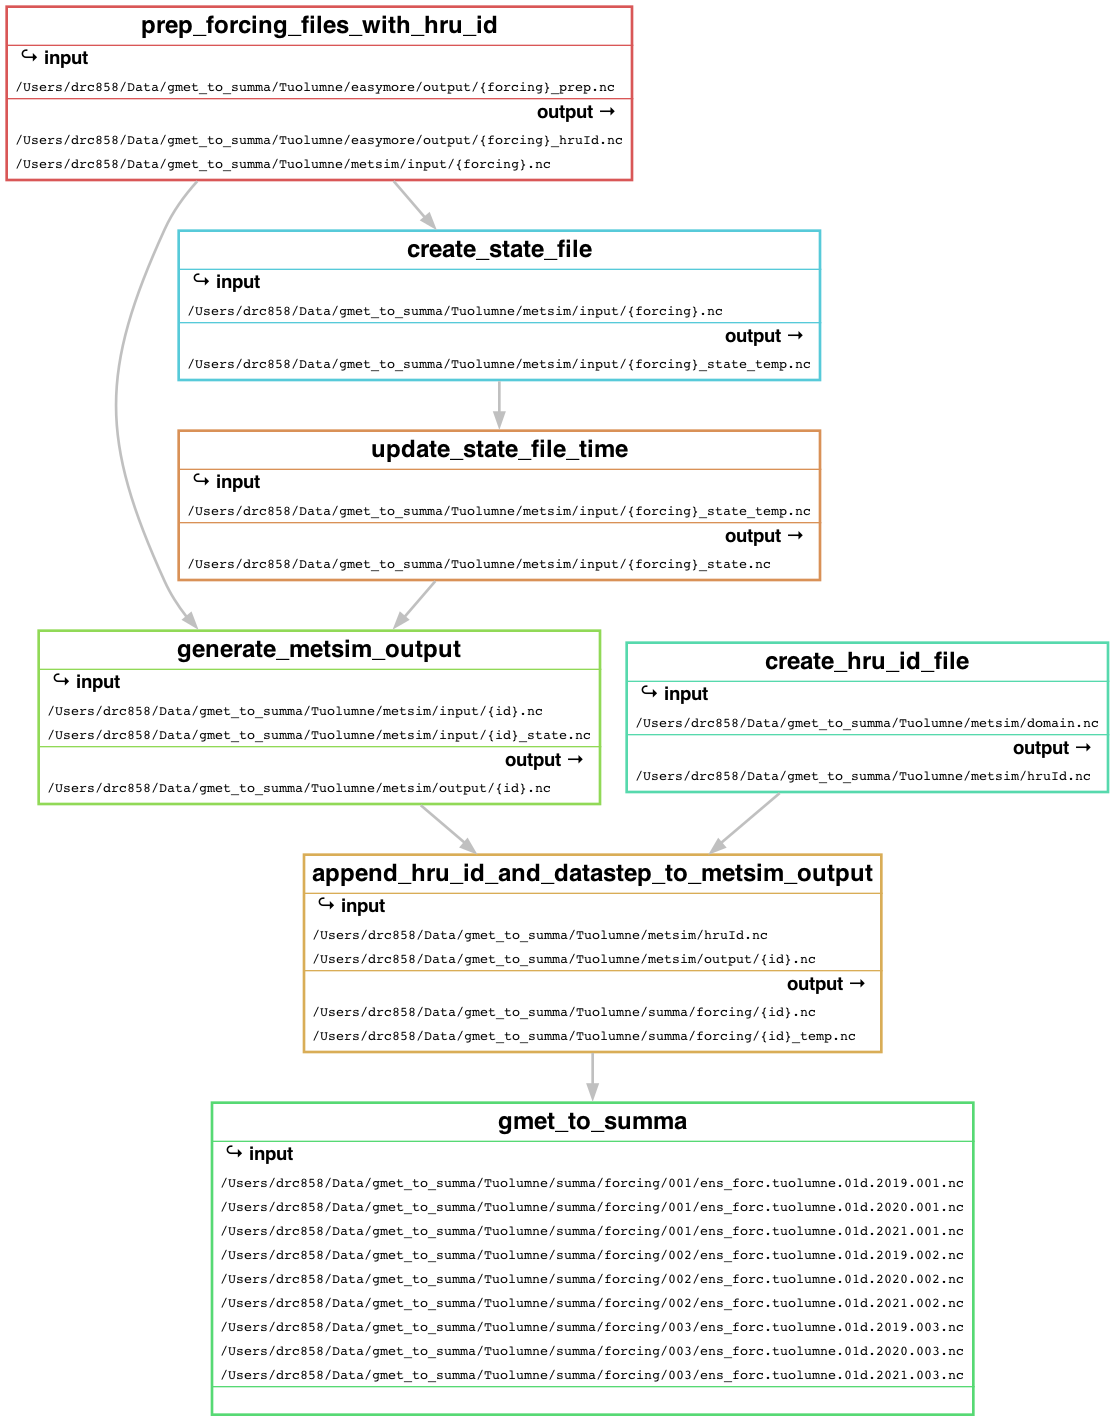

In [107]:
# Snake Command line to build the image
! snakemake -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml --filegraph | dot -Tpng > ../reports/gmet_to_summa.png
# Python command to visualise the built image in our notebook
display.Image('../reports/gmet_to_summa.png')

### Prep GMET files for processing ###

In [100]:
%%writefile ../rules/gmet_file_prep.smk

# This Snakemake file prepares the GMET data for use in 
from pathlib import Path
import sys
sys.path.append('../')
from scripts import gmet_to_summa_utils as utils

# Resolve paths from the configuration file
config = utils.resolve_paths(config)

#Set the list of forcing files to process
#The id is the name of the forcing file without the extension
gmet_forcing_files, = glob_wildcards(Path(config['gmet_forcing_dir'],"{forcing_file}.nc"))

#This first rule establishes the output files that will be created
rule gmet_file_prep:
    input:
        expand(Path(config['gmet_tmp_forcing_dir'],"{forcing_file}_prep.nc"), forcing_file=gmet_forcing_files)

#Add greogrian calendar to the time variable, needed for easymore  
rule add_gregorian_to_nc:
    input:  
        input_forcing = Path(config['gmet_forcing_dir'],"{id}.nc")
    output: 
        output_forcing = temp(Path(config['gmet_tmp_forcing_dir'],"{id}_greg.nc"))
    shell: 
        'ncatted -a "calendar,time,o,c,"gregorian"" {input.input_forcing} {output.output_forcing}'

#Process temperature data to create t_max and t_min
rule add_t_max_and_t_min:
    input: 
        input_file = Path(config['gmet_tmp_forcing_dir'],"{id}_greg.nc")
    output:
        temp = temp(Path(config['gmet_tmp_forcing_dir'],"{id}_temp.nc")),
        output_file = Path(config['gmet_tmp_forcing_dir'],"{id}_prep.nc")
    shell:
        """
        ncap2 -s "t_max = t_mean+0.5+t_range" -A {input.input_file} {output.temp};
        ncap2 -s "t_min = t_mean+0.5-t_range" -A {output.temp};
        ncatted -O -a long_name,t_max,o,c,"estimated daily maximum temperature" {output.temp};
        ncatted -O -a long_name,t_min,o,c,"estimated daily minimum temperature" {output.temp};
        cp {output.temp} {output.output_file}
        """

Overwriting ../rules/gmet_file_prep.smk


### Run snakemake file

In [101]:
! snakemake --unlock -s ../rules/gmet_file_prep.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../rules/gmet_file_prep.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-13T170014.740449.snakemake.log


## Remap GMET to SHP ##

In [45]:
%%writefile ../rules/remap_gmet_to_shp.smk

# Import needed packages
from pathlib import Path
import sys
sys.path.append('../')
from scripts import remap_forcing_to_shp
from scripts import gmet_to_summa_utils as gts_utils

# Resolve paths from the configuration file
config = gts_utils.resolve_paths(config)

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
ensemble_list, file_path_list = gts_utils.build_ensemble_list(config['gmet_forcing_dir'])

# Create a list of the temporary forcing files produced in the last workflow
file_tmp_dir = Path(config['gmet_tmp_forcing_dir'])
tmp_forcing_files = list(file_tmp_dir.glob('*'))
       
rule remap_gmet_to_shp:
    input:
        expand(Path(config['easymore_output_dir'],"{file}_prep.nc"), file=file_path_list)

# Define rule to run file remapping when remap file exists
rule create_remap_file:
    input:
        input_forcing_file = tmp_forcing_files[0],
        input_shp = config['catchment_shp']
    output:
        remap_csv = config['remap_file']
    run:
        remap_forcing_to_shp.remap_with_easymore(config, input.input_forcing_file ,input.input_shp, output.remap_csv, only_create_remap_csv=True)

# Define rule to run file remapping when remap file exists
rule remap_with_easymore:
    input:
        input_forcing = Path(file_tmp_dir,"{id}_prep.nc"),
        input_shp = config['catchment_shp'],
        remap_csv = config['remap_file'],
        ens_str = "{id}"[:3]
    output:
        output_forcing = Path(config['easymore_output_dir'],"{id}_prep.nc", file=file_path_list)
    run:
        remap_forcing_to_shp.remap_with_easymore(config, input.input_forcing,input.input_shp,input.remap_csv,ens=ens_str)




Overwriting ../rules/remap_gmet_to_shp.smk


In [46]:
! snakemake --unlock -s ../rules/remap_gmet_to_shp.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/remap_gmet_to_shp.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-13T161900.430101.snakemake.log


## Prepare gmet files for metsim ##

In [62]:
%%writefile ../rules/metsim_file_prep.smk

from pathlib import Path
import sys
import xarray as xr
import numpy as np
import pandas as pd

sys.path.append('../')
from scripts import gmet_to_summa_utils as gts_utils
from scripts import metsim_utils as ms_utils

# Resolve paths from the configuration file
config = gts_utils.resolve_paths(config)

# Create a list of the forcing files produced in the last workflow
input_forcing_list = gts_utils.list_files_in_subdirectory(config['easymore_output_dir'], config['prep_suffix'])

easymore_output = Path(config['easymore_output_dir']) 
metsim_input = Path(config['metsim_input_dir'])

# Main rule to define the files produced by this workflow
rule prepare_metsim_files:
    input:
        Path(config["metsim"]["metsim_dir"], config["metsim_domain_nc"]),
        expand(Path(metsim_input,"{forcing}.nc"), forcing = input_forcing_list),
        expand(Path(metsim_input,"{forcing}_state.nc"), forcing = input_forcing_list)
         
# Create metsim domain file from an existing summa attribute file
rule create_metsim_domain_summa_attr:
    input:
        attr_nc = Path(config["attribute_nc"])
    output:
        domain_nc = Path(config["summa"]["summa_dir"], config["metsim_domain_nc"])
    shell:
        'ncap2 -O -s "mask=elevation*0+1" {input.attr_nc} {output.domain_nc}'

rule subset_metsim_domain_to_forcing:
    input:
        domain_nc = Path(config["summa_dir"], config["metsim_domain_nc"]),
        forcing_file = Path(easymore_output,f'{input_forcing_list[0]}.nc')
    output:
        subset_nc = Path(config["metsim_dir"], config["metsim_domain_nc"])
    run:
        ms_utils.subset_domain_to_forcing(input.domain_nc, input.forcing_file, output.subset_nc)

# Define rule to run file remapping when remap file exists
rule prep_forcing_files_with_hru_id:
    input:
        input_forcing = Path(easymore_output,"{forcing}_prep.nc")
    output:
        hru_id_temp = temp(Path(easymore_output,"{forcing}_hruId.nc")),
        hru_id = Path(metsim_input,"{forcing}.nc")
    shell:
        """
        ncap2 -O -s "hru=array(0,1,hruId)" {input.input_forcing} {output.hru_id_temp};
        ncatted -O -a long_name,hru,a,c,"hru coordinate index" {output.hru_id_temp} {output.hru_id}
        """
        
rule create_state_file:
    input:
        input_forcing_file = Path(metsim_input,"{forcing}.nc")
    output:
        output_state_file = Path(metsim_input,"{forcing}_state_temp.nc")
    run:
        ms_utils.create_state_file(input.input_forcing_file, output.output_state_file)

rule update_state_file_time:
    input:
        input_state_file = Path(metsim_input,"{forcing}_state_temp.nc")
    output:
        output_state_file = Path(metsim_input,"{forcing}_state.nc")
    run:
        gts_utils.update_time_units(input.input_state_file, output.output_state_file)

Overwriting ../rules/metsim_file_prep.smk


In [61]:
! snakemake --unlock -s ../rules/metsim_file_prep.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/metsim_file_prep.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                       count    min threads    max threads
----------------------  -------  -------------  -------------
create_state_file             9              1              1
prepare_metsim_files          1              1              1
update_state_file_time        9              1              1
total                        19              1              1

Select jobs to execute...

[Thu Jul 13 16:27:10 2023]
rule create_state_file:
    input: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2019.001.nc
    output: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2019.001_state_temp.nc
    jobid: 11
    reason: Missing output files: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2019.001_state_temp.nc
    wildcards: forcing=

## Run metsim ##

In [83]:
%%writefile ../rules/run_metsim.smk
from pathlib import Path

sys.path.append('../')
from scripts import gmet_to_summa_utils as gts_utils
from scripts import metsim_utils as ms_utils

# Resolve paths from the configuration file
config = gts_utils.resolve_paths(config)

# Generate list of forcing files to create wildcards
input_forcing_list = gts_utils.list_files_in_subdirectory(Path(config['easymore_output_dir']), config['prep_suffix'])

rule run_metsim:
    input:
        expand(Path(config['metsim_output_dir'],"{id}.nc"), id=input_forcing_list)

rule generate_metsim_output:
    input:
         metsim_input_forcing = Path(config['metsim_input_dir'],"{id}.nc"),
         metsim_input_state = Path(config['metsim_input_dir'],"{id}_state.nc")
    output:
        metsim_output_forcing = Path(config['metsim_output_dir'],"{id}.nc")
    run:
        ms = ms_utils.create_metsim_config(config, input.metsim_input_forcing,input.metsim_input_state,output.metsim_output_forcing)
        ms.run()
        ms_utils.rename_metsim_output(ms,output.metsim_output_forcing)



Overwriting ../rules/run_metsim.smk


In [89]:
! snakemake --unlock -s ../rules/run_metsim.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/run_metsim.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                       count    min threads    max threads
----------------------  -------  -------------  -------------
generate_metsim_output        9              1              1
run_metsim                    1              1              1
total                        10              1              1

Select jobs to execute...

[Thu Jul 13 16:46:18 2023]
rule generate_metsim_output:
    input: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2020.001.nc, /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2020.001_state.nc
    output: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/output/001/ens_forc.tuolumne.01d.2020.001.nc
    jobid: 3
    reason: Missing output files: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/output/001/ens_forc.tuolumne.01d.2020.001.nc
 

## Convert metsim output to summa ready input ##

In [73]:
%%writefile ../rules/metsim_to_summa.smk
from pathlib import Path

# Import custom functions
sys.path.append('../')
from scripts import gmet_to_summa_utils as gts_utils

# Resolve paths from the configuration file
config = gts_utils.resolve_paths(config)

input_forcing_list = gts_utils.list_files_in_subdirectory(config['metsim_output_dir'], '.nc')

rule metsim_to_summa:
    input:
        expand(Path(config['summa_forcing_dir'],"{id}.nc"), id=input_forcing_list)

rule create_hru_id_file:
    input:
        subset_domain_file = Path(config["metsim"]["metsim_dir"], config["metsim_domain_nc"])
    output:
        hru_id_file = temp(Path(config["metsim"]["metsim_dir"], 'hruId.nc'))
    shell:
        'ncks -v hruId {input.subset_domain_file} {output.hru_id_file}'

rule append_hru_id_and_datastep_to_metsim_output:
    input:
        input_metsim_file = Path(config['metsim']['metsim_output_dir'],"{id}.nc"),
        hru_id_file = Path(config["metsim"]["metsim_dir"], 'hruId.nc')
    output:
        output_metsim_file_temp = temp(Path(config['summa']['summa_forcing_dir'],"{id}_temp.nc")),
        output_metsim_file = Path(config['summa']['summa_forcing_dir'],"{id}.nc")
    params:
        timestep = int(config["metsim_timestep_minutes"]) * 60
    shell:
        """
        ncks -h -A {input.hru_id_file} {input.input_metsim_file}
        ncks -O -C -x -v hru {input.input_metsim_file} {output.output_metsim_file_temp}
        ncap2 -s "data_step={params.timestep}" {output.output_metsim_file_temp} --append {output.output_metsim_file}
        """

Overwriting ../rules/metsim_to_summa.smk


In [74]:
! snakemake --unlock -s ../rules/metsim_to_summa.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/metsim_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-13T163016.108734.snakemake.log
